# 1: Define an AOI for well distinct, well defined surface classes


In [1]:
import sys
import ee, geemap
import ipywidgets as widgets
import habitat_pl.viz.corine as corine
import importlib
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

ee.Authenticate()
ee.Initialize(project='agh-ml-2025')
importlib.reload(corine)

# to keep things consistent
RANDOM_SEED = 123
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


region = (ee.FeatureCollection('FAO/GAUL/2015/level1')
          .filter(ee.Filter.eq('ADM0_NAME', 'Poland')))

# Annual Satellite Embedding (example: 2021)
emb = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
       .filterDate('2021-01-01','2022-01-01')
       .filterBounds(region)
       .mosaic()
       .clip(region))

# Visualize (pseudo-RGB from embedding bands)
m = geemap.Map()
m.centerObject(region, 8)
m.addLayer(emb, {'min':-0.3,'max':0.3,'bands':['A01','A16','A09']}, 'Embeddings 2021')

# Loads CORINE Land Cover 2018 raster (44 classes, 100 m resolution).
clc = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(region)

# Remaps CORINE class codes (111…523) to sequential indices (1…44).
clc_idx = clc.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')

# Adds the CORINE raster to the map, colored according to EEA’s palette
m.addLayer(clc_idx, corine.vis, 'CORINE 2018')

# Creates a scrollable legend showing all 44 class names with their corresponding colors.
legend = m.add_legend(title="CORINE Land Cover 2018", legend_dict=corine.legend_dict)

m

d:\studia\Y5S1\ML_for_Space_Tech_2\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.5) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)



Successfully saved authorization token.


Map(center=[52.10873611973873, 19.430639807941695], controls=(WidgetControl(options=['position', 'transparent_…

In [2]:
aoi = m.draw_last_feature

if aoi is None:
    assert False, "Please draw an AOI polygon on the map."
else:
    aoi_proper = aoi.geometry()
    print("AOI drawn and buffered.")

AOI drawn and buffered.


For this class I picked a region in the Warmińsko-Mazurskie Voivodeship with a lake, city and forest in it (among other things). This should work nicely and be relatively easy to separate.

# 2: Download GSE and CORINE labels for the defined AOI

In [3]:
# Get GSE samples from 2021 (same as map visualization)
gse_2021 = (ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
            .filterDate('2021-01-01', '2022-01-01')
            .filterBounds(aoi_proper)
            .mosaic()
            .clip(aoi_proper))

gse_bands = [b for b in gse_2021.bandNames().getInfo() if b.startswith('A')]

# Extract CORINE labels for the same region
corine_data = ee.Image('COPERNICUS/CORINE/V20/100m/2018').select('landcover').clip(aoi_proper)
# Remap CORINE codes to sequential indices
corine_idx = corine_data.remap(corine.codes, list(range(1, len(corine.codes)+1))).rename('landcover_idx')
# Delete pixels with no data
gse_masked = gse_2021.updateMask(corine_idx.gt(0))

print(f"✓ GSE and CORINE data extracted for AOI")

✓ GSE and CORINE data extracted for AOI


#### Prepare data for next steps

In [4]:
# Embedding class indexes
comb = gse_masked.select(gse_bands).addBands(corine_idx)

# Remove indexes that dont appear in our AOI
def sample(idx):
    image = comb.updateMask(corine_idx.eq(idx))
    return image.sample(region=aoi_proper, scale=100, geometries=False, numPixels=1e13, seed=RANDOM_SEED)

valid_classes = (corine_idx.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(), geometry=aoi_proper, scale=100)
    .get('landcover_idx').getInfo())
valid_idx = sorted([int(k) for k in valid_classes.keys()])

filtered_idx = [sample(idx) for idx in valid_idx]
samples = ee.FeatureCollection(filtered_idx).flatten()

df = geemap.ee_to_df(samples)
df = df.dropna().reset_index(drop=True)

print(f"✓ Extracted {len(df)} samples from {len(valid_idx)} classes.")
print("Class distribution:")
print(df['landcover_idx'].value_counts())

✓ Extracted 6242 samples from 7 classes.
Class distribution:
landcover_idx
41    2542
2     1602
12     961
23     788
11     143
3      114
9       92
Name: count, dtype: int64


In [5]:
MAX_PER_CLASS = 200
# Balancing
def balance_df(df, label_col='landcover_idx', max_per_class=MAX_PER_CLASS, seed=RANDOM_SEED):
    parts = []
    for cls, sub in df.groupby(label_col):
        if len(sub) > max_per_class:
            parts.append(sub.sample(max_per_class, random_state=seed))
        else:
            parts.append(sub)
    return pd.concat(parts, axis=0).sample(frac=1.0, random_state=seed).reset_index(drop=True)

df_bal = balance_df(df)
print("Class distribution after balancing:")
print(df_bal['landcover_idx'].value_counts())

Class distribution after balancing:
landcover_idx
12    200
41    200
23    200
2     200
11    143
3     114
9      92
Name: count, dtype: int64


In [6]:
X = df_bal[gse_bands].values
y = df_bal['landcover_idx'].astype(int).values

# 3: Apply PCA, t-SNE and UMAP dimensionality reductions to GSE samples

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
## variables for dimensionality reduction
TSNE_PERPLEXITY = 30
UMAP_N_NEIGHBORS = 15
UMAP_MIN_DIST = 0.1


# PCA (2D)
pca_2d = PCA(n_components=2, random_state=RANDOM_SEED).fit_transform(X)

# t-SNE (2D)
tsne_2d = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, learning_rate='auto',
               init='pca', random_state=RANDOM_SEED).fit_transform(X)

# UMAP (2D)
umap_2d = umap.UMAP(n_neighbors=UMAP_N_NEIGHBORS, min_dist=UMAP_MIN_DIST,
                    n_components=2, metric='euclidean', random_state=RANDOM_SEED).fit_transform(X)

# 4: Annotate the 2D visualisation with CORINA labels

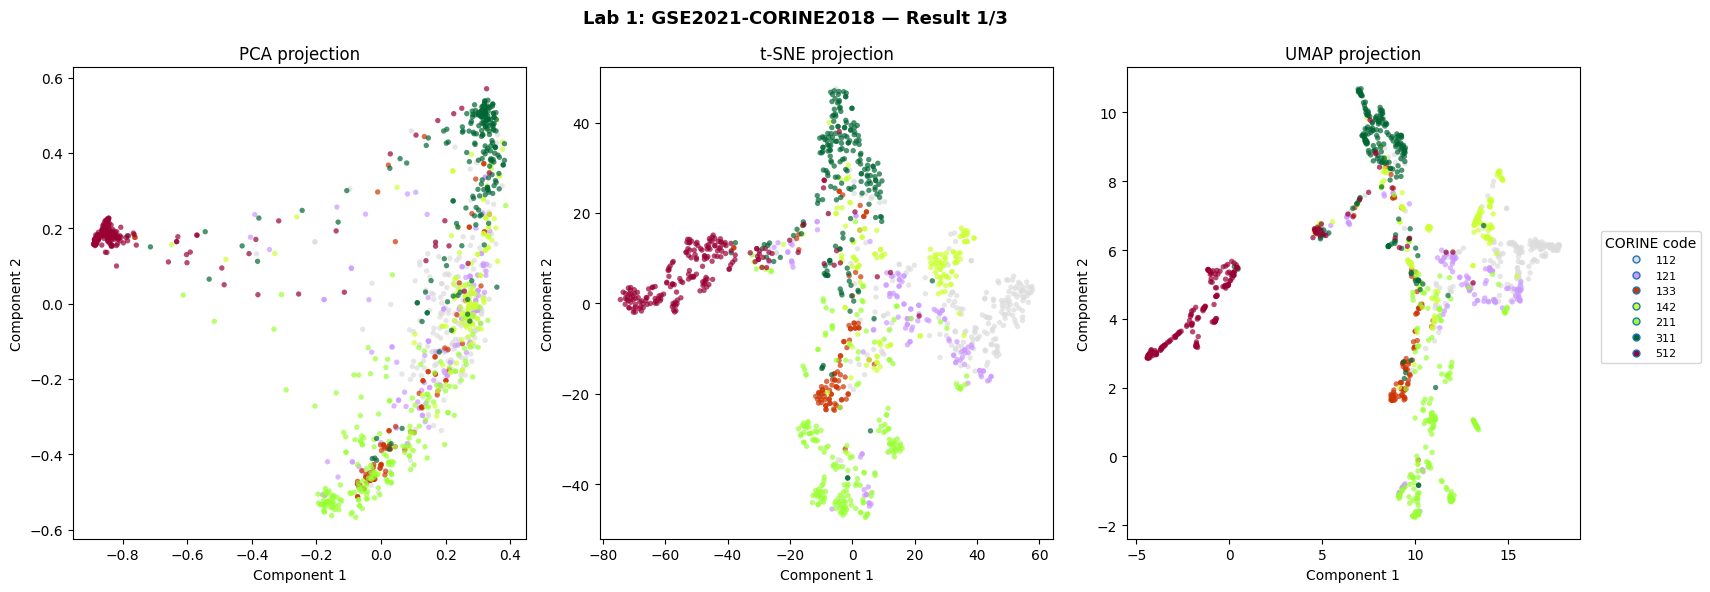

In [8]:
idx_to_code = {i+1: code for i, code in enumerate(corine.codes)}
code_to_name = {int(k[:3]): k[4:] for k in corine.legend_dict.keys()}

def _norm_hex(c):
    return c if isinstance(c, str) and c.startswith('#') else f'#{c}'

palette = [_norm_hex(c) for c in corine.vis['palette']]
idx_to_color = {i+1: palette[i] for i in range(len(palette))}

unique_idx = sorted(np.unique(y))

# Plotting with code-only labels
fig, axes = plt.subplots(1, 3, figsize=(16, 6), dpi=100)
for ax, xy, name in zip(
    axes,
    [pca_2d, tsne_2d, umap_2d],
    ['PCA projection','t-SNE projection','UMAP projection']
):
    for cls in unique_idx:
        m = (y == cls)
        if not m.any():
            continue
        ax.scatter(
            xy[m, 0], xy[m, 1],
            s=15, alpha=0.7,
            color=idx_to_color.get(cls, '#000000'),
            edgecolors='none'
        )
    ax.set_title(name, fontsize=12)
    ax.set_xlabel('Component 1', fontsize=10)
    ax.set_ylabel('Component 2', fontsize=10)
    ax.grid(False)

# Create legend with code-only labels
handles, labels = [], []
for cls in unique_idx:
    handles.append(plt.Line2D([0],[0], marker='o', linestyle='',
                              markersize=5, markerfacecolor=idx_to_color.get(cls, '#000000')))
    labels.append(str(idx_to_code.get(cls, cls)))
fig.legend(handles, labels, title="CORINE code", bbox_to_anchor=(1.0, 0.5), 
           loc='center left', fontsize=8, ncol=1)

fig.suptitle("Lab 1: GSE2021-CORINE2018 — Result 1/3", fontsize=13, weight='bold')
plt.tight_layout()
plt.show()

#### How does the PCA, t-SNE and UMAP dimension reduction algorithms compare?

In this case I'd say UMAP does the best job, followed by t-SNE. All three can separate the water rather well, but PCA suffers when it comes to the rest the most.

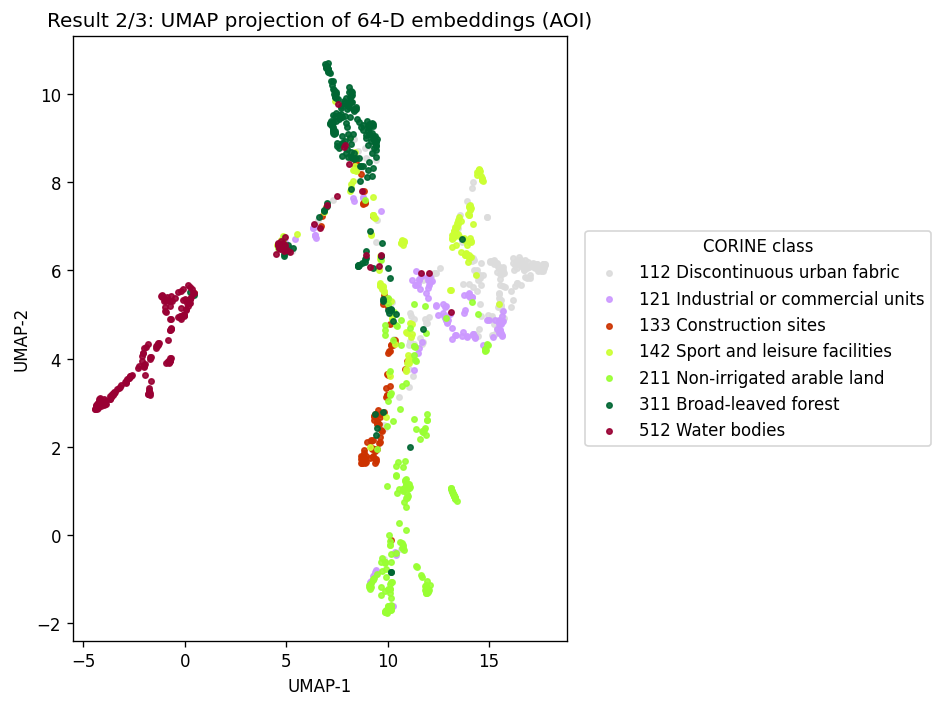

In [9]:

fig, ax = plt.subplots(1,1, figsize=(8,6), dpi=120)
for cls in unique_idx:
    m = (y == cls)
    if not m.any():
        continue
    ax.scatter(umap_2d[m,0], umap_2d[m,1], s=10, alpha=0.9,
               color=idx_to_color.get(cls, '#000000'), 
               label=f"{idx_to_code.get(cls, cls)} {code_to_name.get(idx_to_code.get(cls), '')}")
ax.set_xlabel('UMAP-1')
ax.set_ylabel('UMAP-2')
ax.set_title('Result 2/3: UMAP projection of 64-D embeddings (AOI)')
ax.legend(title='CORINE class', loc='center left', bbox_to_anchor=(1.02, 0.5))
ax.grid(False)
plt.tight_layout()
plt.show()


#### Result 3/3: What were your main challenges with obtaining the results (if any)?

all good